In [1]:
from torch.utils.data import Dataset
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn import decomposition
from random import randint

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class WeatherBenchDatasetWindow(Dataset):
    def __init__(self, data, context_length, stride=1):
        self.data = data
        self.context_length = context_length
        self.stride = stride
        
    def __len__(self):
        return (self.data.shape[0] - self.context_length) // self.stride + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.context_length]
        y = idx
        return x, y

In [4]:
model = torch.load('barlow_decoder_fine_tuned_test_180.pth', weights_only=False, map_location=DEVICE)
model.eval()

model = model.model.encoder

BATCH_SIZE = 500
data = torch.load('/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt')
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train:n_train+n_valid]
test_data = data[n_train+n_valid:]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDatasetWindow(data=test_data, context_length=30, stride=1)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [5]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[0].to(DEVICE)
y = batch[1].to(DEVICE)

In [6]:
B, T, C, H, W = x.shape
x = x.reshape(B*T, C, H, W)
with torch.no_grad():
    embeddings_x, _ = model(x)
embeddings_x = embeddings_x.reshape(B, T, -1)
embeddings_x = embeddings_x.reshape(B, -1)

In [7]:
embeddings_x = embeddings_x.cpu().numpy()
y = y.cpu().numpy()
pca = TSNE(n_components = 2)
pca_embeddings_x = pca.fit_transform(embeddings_x)

plot_num = 100

df = pd.DataFrame({
    'x': pca_embeddings_x[:plot_num, 0],
    'y': pca_embeddings_x[:plot_num, 1],
    'labels': y[:plot_num]
})

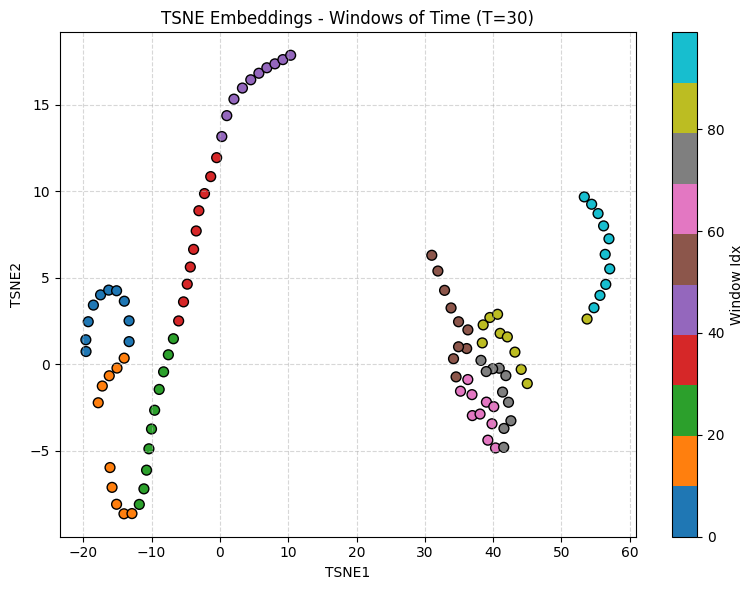

In [8]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['x'], df['y'], c=df['labels'], cmap='tab10', s=50, edgecolors='k')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('TSNE Embeddings - Windows of Time (T=30)')
plt.colorbar(scatter, label='Window Idx')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [9]:
# sorted_df = df.sort_values('labels')  # assuming labels = time windows
# plt.figure(figsize=(8, 6))
# plt.scatter(sorted_df['x'], sorted_df['y'], c=sorted_df['labels'], cmap='viridis', s=40)
# plt.plot(sorted_df['x'], sorted_df['y'], color='gray', alpha=0.5)  # path line
# plt.title('Temporal Evolution in PCA Space')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.colorbar(label='Time Window')
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

In [10]:
from sklearn.metrics.pairwise import pairwise_distances
D_cos = pairwise_distances(embeddings_x, metric='cosine')
D_euc = pairwise_distances(embeddings_x, metric='euclidean')

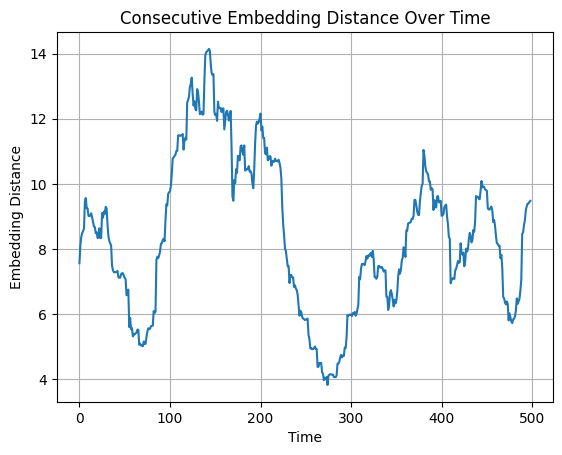

In [11]:
distances = np.linalg.norm(embeddings_x[1:] - embeddings_x[:-1], axis=1)
plt.plot(distances)
plt.title('Consecutive Embedding Distance Over Time')
plt.xlabel('Time')
plt.ylabel('Embedding Distance')
plt.grid(True)
plt.show()

[[1.9544508e-05 7.5619836e+00 1.2200927e+01 1.6067343e+01 1.8437111e+01
  2.0795031e+01 2.2950478e+01 2.2702494e+01 2.1084158e+01 1.9031393e+01
  1.7038010e+01 1.5559200e+01 1.4409951e+01 1.4276978e+01 1.5834122e+01
  1.7919300e+01 1.9441816e+01 2.0849968e+01 2.1787575e+01 2.2304670e+01
  2.2711163e+01 2.2141138e+01 2.1083366e+01 2.0365652e+01 2.0577499e+01
  2.1023100e+01 2.2481472e+01 2.4376564e+01 2.5515507e+01 2.5389034e+01
  2.5431793e+01 2.5505054e+01 2.5029421e+01 2.3722351e+01 2.3244268e+01
  2.2989641e+01 2.2908806e+01 2.4694584e+01 2.6549067e+01 2.7727638e+01
  2.8878256e+01 2.9874474e+01 3.0698854e+01 3.1686949e+01 3.2755444e+01
  3.3719856e+01 3.4500462e+01 3.5201546e+01 3.6306541e+01 3.7575893e+01
  3.8662716e+01 3.9820518e+01 4.0817677e+01 4.1511009e+01 4.2006874e+01
  4.2780495e+01 4.3135014e+01 4.3126942e+01 4.3322426e+01 4.3728344e+01
  4.4054359e+01 4.4552631e+01 4.5162037e+01 4.6046013e+01 4.6959896e+01
  4.7561699e+01 4.7560795e+01 4.7036869e+01 4.6650589e+01 4.6510

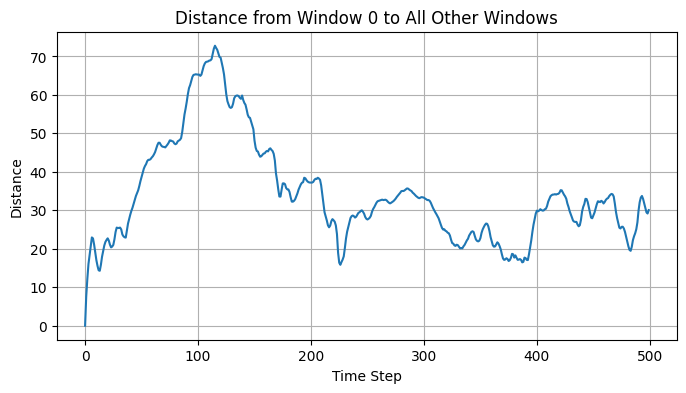

In [12]:
t = 0
dists_to_t = pairwise_distances(
    embeddings_x[t].reshape(1, -1),
    embeddings_x,
    metric='euclidean' 
)
print(dists_to_t)
dists_to_t = dists_to_t.flatten()
plt.figure(figsize=(8, 4))
plt.plot(dists_to_t)
plt.title(f'Distance from Window {t} to All Other Windows')
plt.xlabel('Time Step')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

In [13]:
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, metric='precomputed', init='random')
# tsne_coords = tsne.fit_transform(D_euc)

# plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], c=np.arange(B), cmap='viridis')
# plt.title('t-SNE of Window Embeddings')
# plt.colorbar(label='Time')
# plt.show()